## Dogs v Cats super-charged!

## Added header for Google Colaboratory


In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
# Safe for Colab
%matplotlib inline

Install torch compatible with fastai:

In [2]:
# Not sure are this libs are still count as missing on a clean Colab VM.
!apt-get -qq install -y libsm6 libxext6 

# Install torch compatible with fastai
# TODO: need to test on a clean Colab VM.
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl fastai torchvision

plotnine 0.4.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.


### Special additions for particular lessons

The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. `wget http://files.fast.ai/data/dogscats.zip`. You should put the data in a subdirectory of this notebook's directory, called `data/`. Note that this data is already available in Crestle and the Paperspace fast.ai template.

In [5]:
# The dataset is available at http://files.fast.ai/data/dogscats.zip.
!mkdir -p data
!wget -q http://files.fast.ai/data/dogscats.zip
!unzip -q dogscats.zip -d data/

--2018-09-01 08:11:35--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  34.7MB/s    in 24s     

2018-09-01 08:12:00 (33.7 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



In [7]:
# Model weights for other network architectures (e.g. resnext50):
!wget -q http://files.fast.ai/models/weights.tgz && tar -xzf weights.tgz -C /usr/local/lib/python3.6/dist-packages/fastai

--2018-09-01 08:13:48--  http://files.fast.ai/models/weights.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1195411318 (1.1G) [text/plain]
Saving to: ‘weights.tgz’

weights.tgz         100%[===================>]   1.11G  34.1MB/s    in 34s     

2018-09-01 08:14:22 (33.5 MB/s) - ‘weights.tgz’ saved [1195411318/1195411318]



In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogscats/"
sz=299
arch=resnext50
bs=28

In [0]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [10]:
learn.fit(1e-2, 1)
learn.precompute=False

epoch      trn_loss   val_loss   accuracy   
    0      0.041504   0.021033   0.992     



In [11]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.041571   0.022564   0.993     
    1      0.032412   0.025719   0.9925    



[array([0.02572]), 0.9925000027418137]

In [0]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [13]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.044288   0.01593    0.995     
    1      0.030287   0.015244   0.995     
    2      0.026455   0.016416   0.9945    



[array([0.01642]), 0.9945000026226044]

In [0]:
learn.save('224_all_50')

In [0]:
learn.load('224_all_50')

In [16]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.994

In [0]:
?metrics.log_loss(y, np.exp(log_preds)), accuracy(log_preds,y)

## Analyzing results

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[993   7]
 [  5 995]]


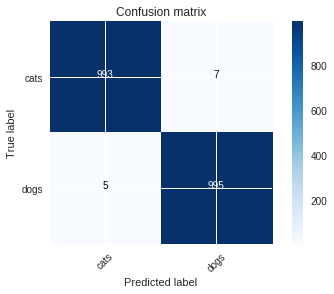

In [18]:
plot_confusion_matrix(cm, data.classes)

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


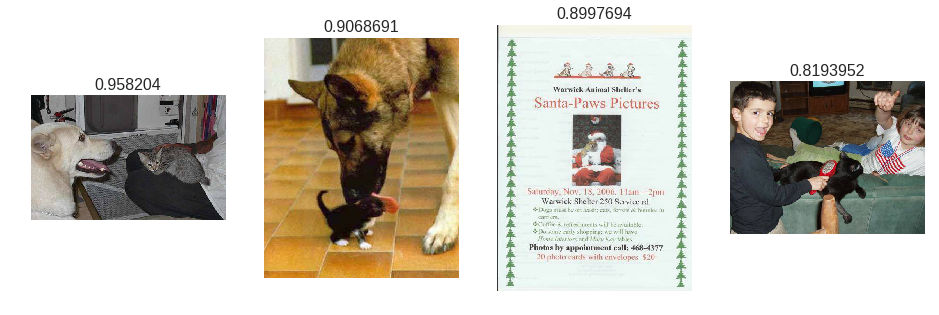

In [20]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


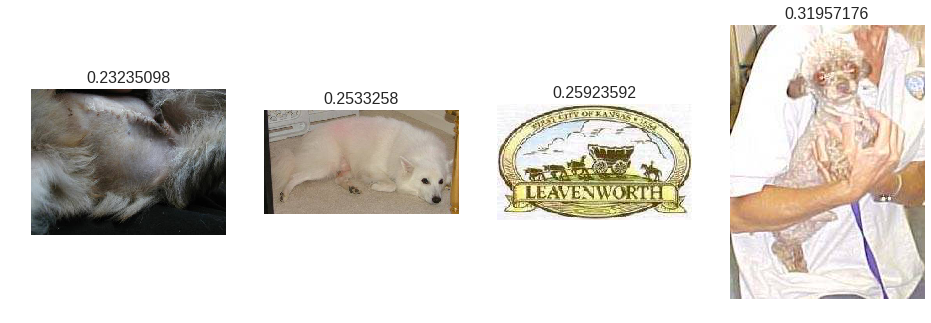

In [21]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")